## Part 1 - Article Sentiment information extraction 

In [20]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import re
import csv 
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ball4308/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
dfv = pd.read_csv("df_transed_cleaned.csv").drop(columns = ['Unnamed: 0'])
dfv['publish_date'] = pd.to_datetime(dfv['publish_date'])
dfv['date'] = dfv['publish_date'].apply(lambda x: x.date())
dfv = dfv.drop(columns =['translateda_mix','translateda_headline','translateda_headline_cleaned',
                         'translateda_mix_dic','translateda_headline_dic'])
dfv = dfv.rename(columns = {'translateda_mix_cleaned':'transated_mix_cleaned'})                    
dfv.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,scraped_article,title_FB_only,BOG,date,transated_mix_cleaned
0,865782065,2015-01-03 18:12:00,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",https://twitter.com/TheRalphRetort/status/5515...,en,False,NaN,18346,Twitter,http://twitter.com,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",NaN,NaN,2015-01-03,ralph twitter appreciate big help
1,335784736,2015-01-07 07:23:39,The Daily Rupert on Twitter: &quot;Facebook v...,https://twitter.com/TheMurdochTimes/status/552...,en,False,NaN,18346,Twitter,http://twitter.com,The Daily Rupert on Twitter: &quot;Facebook v...,NaN,NaN,2015-01-07,daily twitter video image terrorist outside of...
2,335817091,2015-01-07 12:32:58,teleSUR TV on Twitter: &quot;El Festival de Ca...,https://twitter.com/teleSURtv/status/552880585...,en,False,NaN,18346,Twitter,http://twitter.com,teleSUR TV on Twitter: &quot;El Festival de Ca...,NaN,NaN,2015-01-07,twitter festival de en en
3,320258910,2015-01-15 21:39:09,Stop Patriarchy on Twitter: &quot;Tune in to n...,https://twitter.com/StopPatriarchy/status/5559...,en,False,NaN,18346,Twitter,http://twitter.com,Stop Patriarchy on Twitter: &quot;Tune in to n...,NaN,NaN,2015-01-15,stop patriarchy twitter join event
4,372077690,2015-01-24 07:00:00,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,https://archive.is/ArtrI,en,False,computers and the internet,18346,Twitter,http://twitter.com,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,NaN,NaN,2015-01-24,blocker twitter kop could not keep mouth shut ...


In [14]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7732 entries, 0 to 7731
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   stories_id             7732 non-null   int64         
 1   publish_date           7729 non-null   datetime64[ns]
 2   title                  7732 non-null   object        
 3   url                    7732 non-null   object        
 4   language               7716 non-null   object        
 5   ap_syndicated          7732 non-null   bool          
 6   themes                 1478 non-null   object        
 7   media_id               7732 non-null   int64         
 8   media_name             7732 non-null   object        
 9   media_url              7732 non-null   object        
 10  scraped_article        7732 non-null   object        
 11  title_FB_only          3928 non-null   object        
 12  BOG                    3928 non-null   object        
 13  dat

### Thanks for Jason: 
### We can use the lexicon based sentiment analyser to convert the clenaed article into 

In [11]:
# # stock market lexicon
stock_lex = pd.read_csv("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/stock_lex.csv")
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
     if v > 0:
         stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
     else:
         stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

### We used the Loughran and McDonald lexicon to represent the words represent positive and negative sentiment in the stock market 

In [12]:
### Loughran and McDonald
positive = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_positive.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         positive.append(row[0].strip())
    
negative = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_negative.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         entry = row[0].strip().split(" ")
         if len(entry) > 1:
             negative.extend(entry)
         else:
             negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [16]:
dfv['transated_mix_cleaned'] = dfv['transated_mix_cleaned'].astype(str)
dfv['article_sentiment'] =  dfv['transated_mix_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [22]:
senti_score = dfv.groupby('date')[['article_sentiment']].sum()
senti_score.head()

,article_sentiment
date,
2015-01-03,0.8320
2015-01-07,-0.4392
2015-01-15,0.1662
2015-01-24,0.0579
2015-02-05,0.3473


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(senti_score.index), y = senti_score['article_sentiment'],
                    mode='lines',
                    name='sarticle sentiment'))

fig.show()

In [27]:
finance = pd.read_csv('financial_wiki_2017_07_08.csv')
finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 66 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           1282 non-null   object 
 1   Facebook.wiki                  1282 non-null   int64  
 2   Google.wiki                    1282 non-null   int64  
 3   Microsoft.wiki                 1282 non-null   int64  
 4   Amazon (company).wiki          1282 non-null   int64  
 5   Apple Inc..wiki                1282 non-null   int64  
 6   AAPL                           1282 non-null   float64
 7   AMZN                           1282 non-null   float64
 8   FB                             1282 non-null   float64
 9   GOOGL                          1282 non-null   float64
 10  MSFT                           1282 non-null   float64
 11  FB_return                      1282 non-null   float64
 12  FB_change                      1282 non-null   f

### Log transformation for Wikipedia page view to better handle outlier 

In [10]:
amazon = [x for x in (data.columns) if 'Amazon (company).wiki' in x]
print(amazon)
data = data.drop(columns = amazon)
data.head()

['Amazon (company).wiki', 'Amazon (company).wiki_t-1', 'Amazon (company).wiki_t-2', 'Amazon (company).wiki_t-3', 'Amazon (company).wiki_t-1_t-2', 'Amazon (company).wiki_t-2_t-3', 'Amazon (company).wiki_t-3_t-4']


,Facebook.wiki,Google.wiki,Microsoft.wiki,Apple Inc..wiki,AAPL,AMZN,FB,GOOGL,MSFT,FB_return,...,warn_t-2,bury_t-2,fair_t-2,unqualified_t-2,suspension_t-2,angrily_t-2,banner_t-2,properly_t-2,wait_t-2,disclosure_t-2
date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,46622,42652,7816,12394,113.411430,443.510010,87.949997,556.109985,40.275764,0.024103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-13,47063,44437,7857,12479,115.600922,455.570007,90.099998,571.729980,41.115414,0.024446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-14,44508,45269,7314,11447,115.554909,465.570007,89.680000,584.179993,41.187630,-0.004661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-15,44555,44688,7583,10436,116.668060,461.190002,89.760002,583.960022,41.314034,0.000892,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-16,45184,44310,7442,10174,118.222786,475.480011,90.849998,601.780029,42.126591,0.012143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
non_text_features = [x for x in non_text_features if  x not in amazon]
print(len(non_text_features))

39


In [12]:
non_text_features[:12]

['Facebook.wiki_t-1',
 'Facebook.wiki_t-2',
 'Facebook.wiki_t-3',
 'Google.wiki_t-1',
 'Google.wiki_t-2',
 'Google.wiki_t-3',
 'Microsoft.wiki_t-1',
 'Microsoft.wiki_t-2',
 'Microsoft.wiki_t-3',
 'Apple Inc..wiki_t-1',
 'Apple Inc..wiki_t-2',
 'Apple Inc..wiki_t-3']

## log trans for wiki t- n 

Facebook.wiki_t-1
Facebook.wiki_t-2
Facebook.wiki_t-3
Google.wiki_t-1
Google.wiki_t-2
Google.wiki_t-3
Microsoft.wiki_t-1
Microsoft.wiki_t-2
Microsoft.wiki_t-3
Apple Inc..wiki_t-1
Apple Inc..wiki_t-2
Apple Inc..wiki_t-3


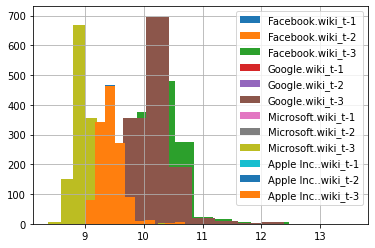

In [13]:
for features in non_text_features[:12]: 
    if 'wiki' in features: 
        if 't-1_t-2' not in features: 
            if 't-2_t-3' not in features: 
                 if 't-3_t-4' not in features: 
                    print(features) 
                    data[features] = np.log(data[features])
                    data[features].hist(legend = True)

In [14]:
non_text_features[12:]

['FB_return_t-1',
 'FB_return_t-2',
 'FB_return_t-3',
 'GOOGL_return_t-1',
 'GOOGL_return_t-2',
 'GOOGL_return_t-3',
 'MSFT_return_t-1',
 'MSFT_return_t-2',
 'MSFT_return_t-3',
 'AMZN_return_t-1',
 'AMZN_return_t-2',
 'AMZN_return_t-3',
 'AAPL_return_t-1',
 'AAPL_return_t-2',
 'AAPL_return_t-3',
 'Facebook.wiki_t-1_t-2',
 'Facebook.wiki_t-2_t-3',
 'Facebook.wiki_t-3_t-4',
 'Google.wiki_t-1_t-2',
 'Google.wiki_t-2_t-3',
 'Google.wiki_t-3_t-4',
 'Microsoft.wiki_t-1_t-2',
 'Microsoft.wiki_t-2_t-3',
 'Microsoft.wiki_t-3_t-4',
 'Apple Inc..wiki_t-1_t-2',
 'Apple Inc..wiki_t-2_t-3',
 'Apple Inc..wiki_t-3_t-4']

In [15]:
data['Facebook.wiki_t-1_t-2'] = data['Facebook.wiki_t-1'] - data['Facebook.wiki_t-2']
data['Facebook.wiki_t-2_t-3'] = data['Facebook.wiki_t-2'] - data['Facebook.wiki_t-3']

In [16]:
data['Google.wiki_t-1_t-2'] = data['Google.wiki_t-1'] - data['Google.wiki_t-2']
data['Google.wiki_t-2_t-3'] = data['Google.wiki_t-2'] - data['Google.wiki_t-3']

In [17]:
data['Microsoft.wiki_t-1_t-2'] = data['Microsoft.wiki_t-1'] - data['Microsoft.wiki_t-2']
data['Microsoft.wiki_t-2_t-3'] = data['Microsoft.wiki_t-2'] - data['Microsoft.wiki_t-3'] 

In [18]:
data['Apple Inc..wiki_t-1_t-2'] = data['Apple Inc..wiki_t-1'] - data['Apple Inc..wiki_t-2']
data['Apple Inc..wiki_t-2_t-3'] = data['Apple Inc..wiki_t-2'] - data['Apple Inc..wiki_t-3']

In [19]:
data = data.drop(columns = ['Facebook.wiki_t-3_t-4',
                            'Microsoft.wiki_t-3_t-4',
                            'Apple Inc..wiki_t-3_t-4',
                            'Google.wiki_t-3_t-4'])

In [20]:
data.head()

,Facebook.wiki,Google.wiki,Microsoft.wiki,Apple Inc..wiki,AAPL,AMZN,FB,GOOGL,MSFT,FB_return,...,warn_t-2,bury_t-2,fair_t-2,unqualified_t-2,suspension_t-2,angrily_t-2,banner_t-2,properly_t-2,wait_t-2,disclosure_t-2
date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,46622,42652,7816,12394,113.411430,443.510010,87.949997,556.109985,40.275764,0.024103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-13,47063,44437,7857,12479,115.600922,455.570007,90.099998,571.729980,41.115414,0.024446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-14,44508,45269,7314,11447,115.554909,465.570007,89.680000,584.179993,41.187630,-0.004661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-15,44555,44688,7583,10436,116.668060,461.190002,89.760002,583.960022,41.314034,0.000892,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-16,45184,44310,7442,10174,118.222786,475.480011,90.849998,601.780029,42.126591,0.012143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
non_text_features = [x for x  in list(data.columns[0:54]) if 't-' in x]
print(len([ x for  x in non_text_features if  'wiki' in x]))
print(len([ x for  x in non_text_features if  'wiki'  not in x]))

20
15


In [22]:
print(len(text_features))

6392


In [23]:
print(len(text_features + list(temp.columns)))

12784


In [24]:
text_f = text_features + list(temp.columns)
print(len(text_f))

12784


## Forecasting 

In [25]:
def MDA(data, predicted_name): 
    correct = 0
    df = data[['FB',predicted_name]].reset_index()
    for i, r in df.iterrows(): 
        if  i  > 0: 
            if r[predicted_name] > df.at[i-1, 'FB']: 
                if r['FB'] > df.at[i-1, 'FB']: 
                    df.at[i,'correct'] = 1
                    correct += 1 
            if r[predicted_name] < df.at[i-1, 'FB']: 
                if r['FB'] < df.at[i-1, 'FB']: 
                    df.at[i,'correct'] = 1
                    correct += 1 
    return (correct/df.shape[0])

In [26]:
train_test_split = 0.80
total_days = len(data.index)
split_week = data.index[round(total_days*(train_test_split))]
train = data[data.index <= split_week]
test = data[data.index > split_week]
print(split_week)
print(train.shape)
print(test.shape)

2019-08-05 00:00:00
(1025, 12838)
(255, 12838)


In [27]:
from sklearn.preprocessing import StandardScaler
x_sc = StandardScaler()
y_sc = StandardScaler()

In [29]:
train_X, train_y = train[non_text_features + text_f], train['FB_return']

In [30]:
test_X, test_y = test[non_text_features + text_f], test['FB_return']

In [31]:
train_X_sc, train_y_sc = x_sc.fit_transform(train_X), y_sc.fit_transform(train_y.values.reshape(-1, 1))
test_X_sc, test_y_sc = x_sc.transform(test_X), y_sc.transform(test_y.values.reshape(-1, 1))

In [32]:
print(train_X_sc.shape, train_y_sc.shape)
print(test_X_sc.shape, test_y_sc.shape)

(1025, 12819) (1025, 1)
(255, 12819) (255, 1)


In [550]:
reg = lgb.LGBMRegressor(max_depth = 10)
reg.fit(train_X_sc,train_y_sc)

LGBMRegressor(max_depth=10)

In [551]:
y_hat_train = y_sc.inverse_transform(reg.predict(train_X_sc)) 
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))
#print(mean_absolute_error(train_y, y_hat_train))
#print(mean_squared_log_error(abs(train_y), abs(y_hat_train)))

<AxesSubplot:xlabel='date'>

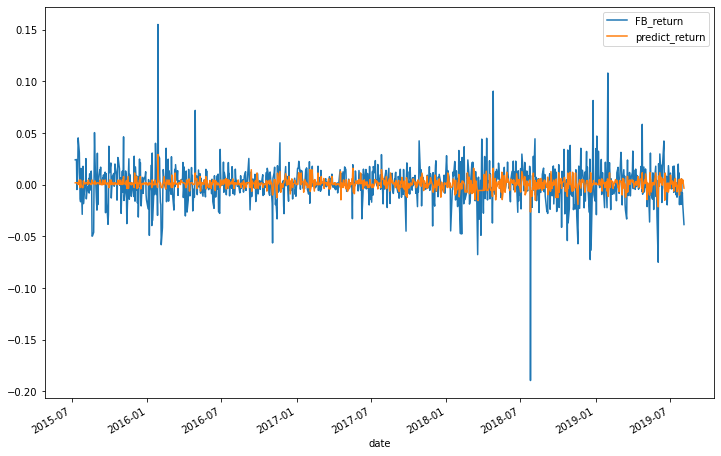

In [552]:
plt.figure(figsize = (12,8))
train['FB_return'].plot(legend = True)
train['predict_return'] = y_hat_train
train['predict_return'].plot(legend = True)

<AxesSubplot:xlabel='date'>

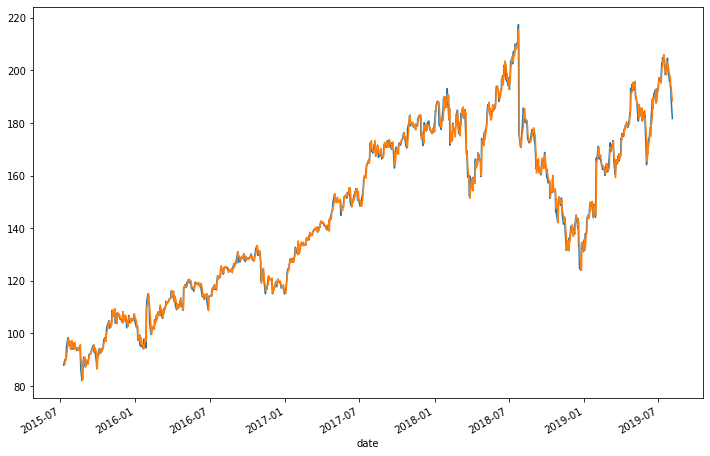

In [553]:
train['predicted_FB'] = train['FB'].shift(1) * (1 + train['predict_return']) 
plt.figure(figsize = (12,8))
train['FB'].plot()
train['predicted_FB'].plot()

In [554]:
print(mean_absolute_error(train['FB'].iloc[1:], train['predicted_FB'].dropna()),'MAE')
print(mean_squared_error(train['FB'].iloc[1:], train['predicted_FB'].dropna()),'RMSE')
print(np.sqrt(mean_squared_log_error(abs(train['FB'].iloc[1:]), abs(train['predicted_FB'].dropna()))),'MLSE')
#print(mda(train['FB'].iloc[1:].values, train['predicted_FB'].dropna().values),'MDA')
print(MDA(train,'predicted_FB'),'MDA')

1.6716333746572858 MAE
6.729575543327723 RMSE
0.01716243515230572 MLSE
0.5912195121951219 MDA


In [555]:
y_hat_test = y_sc.inverse_transform(reg.predict(test_X_sc)) 
test['predict_return'] = y_hat_test 
#print(mean_absolute_error(train_y, y_hat_train))
#print(mean_squared_log_error(abs(train_y), abs(y_hat_train)))

In [556]:
stock_true = test['FB'].shift(1)
stock_true.iloc[0] = train['FB'].iloc[-1]

In [557]:
test['predicted_FB'] = stock_true * (1 + test['predict_return']) 
print(mean_absolute_error(test['FB'], test['predicted_FB']), 'MAE')
print(mean_squared_error(test['FB'], test['predicted_FB']),'RMSE')
print(np.sqrt(mean_squared_log_error(abs(test['FB']), abs(test['predicted_FB']))),'MSLE')
#print(mda(test['FB'].values, test['predicted_FB'].values),'MDA')
print(MDA(test,'predicted_FB'),'MDA')

3.756241052194667 MAE
29.171475422105708 RMSE
0.028092488474184003 MSLE
0.4666666666666667 MDA


<AxesSubplot:xlabel='date'>

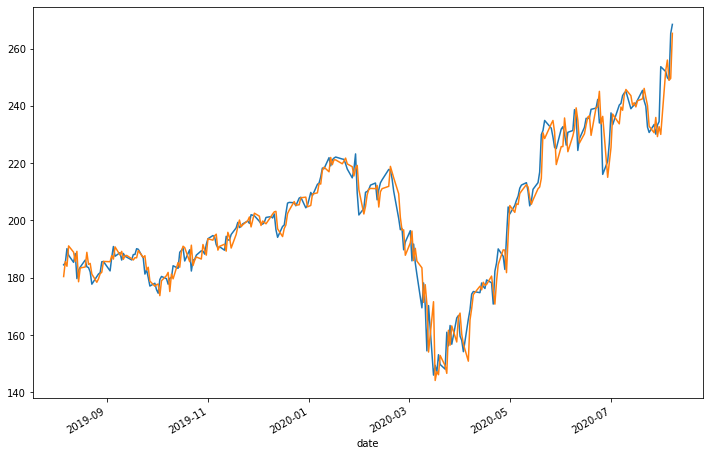

In [558]:
plt.figure(figsize = (12,8))
test['FB'].plot()
test['predicted_FB'].plot()

In [305]:
#Model vlidation 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
reg_valid = LinearRegression()
reg_2 = SVR(kernel='linear')

In [306]:
reg_2.fit(train_X_sc,train_y_sc)

SVR(kernel='linear')

In [307]:
y_hat_train = y_sc.inverse_transform(reg_2.predict(train_X_sc)) 

In [308]:
train['predict_return_linear'] = y_hat_train
train['predict_return_linear']

date
2015-07-10    0.005913
2015-07-13    0.004323
2015-07-14   -0.001579
2015-07-15   -0.000730
2015-07-16   -0.002464
                ...   
2019-07-30   -0.003811
2019-07-31   -0.009454
2019-08-01    0.003389
2019-08-02   -0.000285
2019-08-05    0.004049
Name: predict_return_linear, Length: 1025, dtype: float64

In [309]:
stock_yesterday = [i for i in list(data['FB'].loc["2015-07-10":"2019-08-02"])]
print(len(stock_yesterday))

1024


In [310]:
return_pred = [i for  i in list(train['predict_return_linear'].loc["2015-07-13":'2019-08-05'])]
print(len(return_pred))

1024


In [311]:
pred_stock = [i1 * (1+i2) for (i1,i2) in zip(stock_yesterday,return_pred)]
print(len(pred_stock)) 

1024


In [312]:
train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05'] = pred_stock

<AxesSubplot:xlabel='date'>

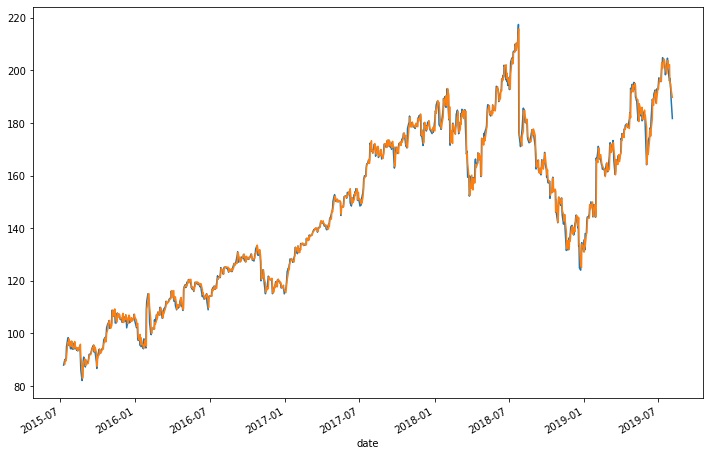

In [313]:
plt.figure(figsize = (12,8))
train['FB'].plot()
train['predicted_FB_linear'].plot()

In [314]:
print(mean_absolute_error(train['FB'].iloc[1:], train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']),'MAE')
print(mean_squared_error(train['FB'].iloc[1:], train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']),'RMSE')
print(np.sqrt(mean_squared_log_error(abs(train['FB'].iloc[1:]), abs(train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']))),'MLSE')
#print(mda(train['FB'].iloc[1:].values, train['predicted_FB_linear'].dropna().values),'MDA')
print(MDA(train, 'predicted_FB_linear'),'MDA')

1.7333561331794698 MAE
7.863847684770526 RMSE
0.018305904817736484 MLSE
0.5619512195121952 MDA


In [315]:
y_hat_test = y_sc.inverse_transform(reg_2.predict(test_X_sc)) 
test['predict_return_linear'] = y_hat_test 

stock_yesterday = [i for i in list(data['FB'].loc['2019-08-05':'2020-08-06'])]
return_pred = [i for  i in list(test['predict_return_linear'])]

pred_stock = [i1 * (1+i2) for (i1,i2) in zip(stock_yesterday,return_pred)]

test['predicted_FB_linear'] = pred_stock
#test['predicted_FB_linear'] = stock_true * (1 + test['predict_return_linear']) 
print(mean_absolute_error(test['FB'], test['predicted_FB_linear']), 'MAE')
print(mean_squared_error(test['FB'], test['predicted_FB_linear']),'RMSE')
print(np.sqrt(mean_squared_log_error(abs(test['FB']), abs(test['predicted_FB_linear']))),'MSLE')
#print(mda(test['FB'].values, test['predicted_FB_linear'].values),'MDA')
print(MDA(test,'predicted_FB_linear'),'MDA')

3.377645544145205 MAE
24.202771131474762 RMSE
0.025628257902058325 MSLE
0.5607843137254902 MDA


In [316]:
test[['FB','predicted_FB_linear']].to_csv('test_to_trade.csv')

In [317]:
df['correct'] = df['correct'].fillna(0)

In [318]:
non_zero_importance_name = train_X.columns[reg.feature_importances_ != 0]
non_zero_importance_value = reg.feature_importances_[reg.feature_importances_ != 0]
print(len(non_zero_importance_name))
print(len(non_zero_importance_value))

37
37


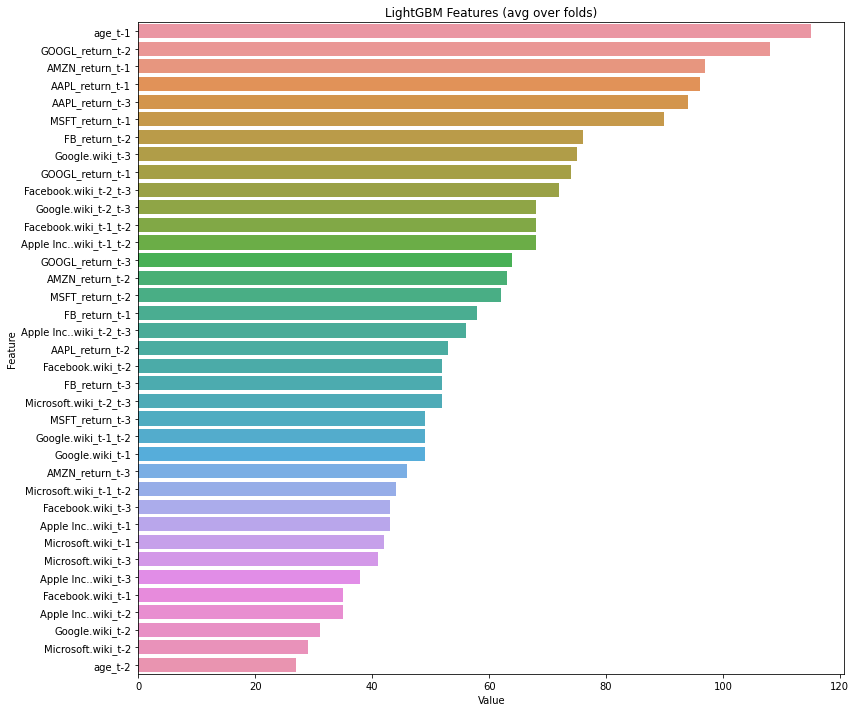

In [319]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(non_zero_importance_value , non_zero_importance_name)), columns=['Value','Feature'])

plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='date'>

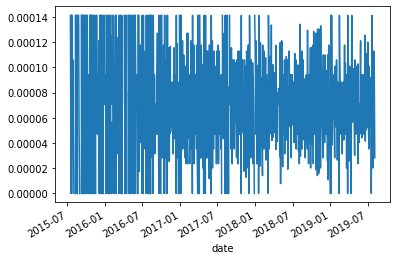

In [573]:
ratio = train['age_t-1']/train[text_f].sum(axis=1)
ratio.plot()

<AxesSubplot:xlabel='date'>

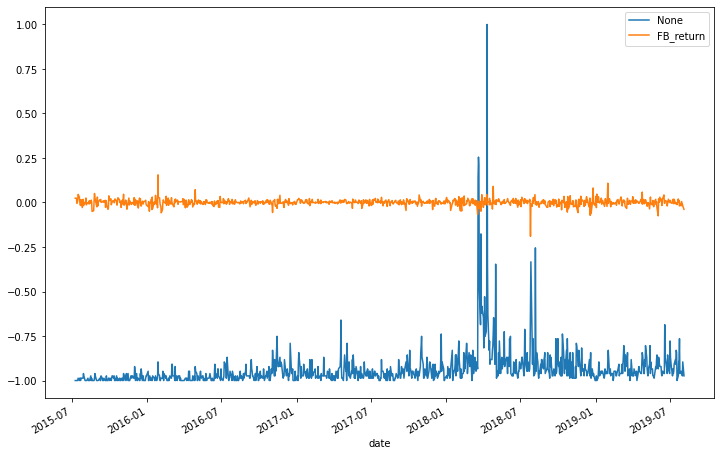

In [649]:
plt.figure(figsize=(12,8))
plt.grid()
train_age.plot(legend = 'train_age_t-1')
train['FB_return'].plot(legend = True)

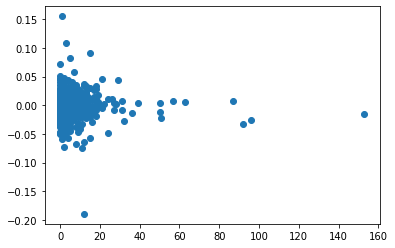

In [652]:
plt.scatter(train['age_t-2'],train['FB_return'])

In [56]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ball4308/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [57]:
import csv
import pandas as pd

# # stock market lexicon
stock_lex = pd.read_csv("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/stock_lex.csv")
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
     if v > 0:
         stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
     else:
         stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

In [58]:
# # # Loughran and McDonald
positive = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_positive.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         positive.append(row[0].strip())
    
negative = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_negative.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         entry = row[0].strip().split(" ")
         if len(entry) > 1:
             negative.extend(entry)
         else:
             negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [34]:
LM = [x.lower() for x in sia.lexicon.keys()]
print(len(LM))

15453


In [35]:
text_f_text = [x[:-4] for x in text_f]
print(len(text_f_text))
not_important_text  = [x for x in text_f_text if x not in LM]
print(len(not_important_text))

12784
5708


In [36]:
delete1 = [x+'_t-1' for x in not_important_text]
delete2 = [x+'_t-2' for x in not_important_text]
data_lm = data.drop(columns = delete1).drop(columns = delete2)
data_lm.shape

(1280, 7130)

In [37]:
im_text = [x for x in text_f_text if x in LM]

In [38]:
train_test_split = 0.80
total_days = len(data_lm.index)
split_week = data_lm.index[round(total_days*(train_test_split))]
train = data_lm[data_lm.index <= split_week]
test = data_lm[data_lm.index > split_week]
print(split_week)
print(train.shape)
print(test.shape)

2019-08-05 00:00:00
(1025, 7130)
(255, 7130)


In [39]:
train_X, train_y = train[list(data_lm.columns[54:])], train['FB_return']
test_X, test_y = test[list(data_lm.columns[54:])], test['FB_return']
train_X_sc, train_y_sc = x_sc.fit_transform(train_X), y_sc.fit_transform(train_y.values.reshape(-1, 1))
test_X_sc, test_y_sc = x_sc.transform(test_X), y_sc.transform(test_y.values.reshape(-1, 1))

In [40]:
print(train_X_sc.shape, train_y_sc.shape)
print(test_X_sc.shape, test_y_sc.shape)

(1025, 7076) (1025, 1)
(255, 7076) (255, 1)


In [44]:
from sklearn.svm import SVR
reg_4 = SVR(kernel = 'linear')
reg_5 = lgb.LGBMRegressor(max_depth = 10)

In [317]:
def train_test(reg, train_X_sc, train_y_sc, test_X_sc, test_y_sc , LGBM = True, SVR = True): 

    reg.fit(train_X_sc,train_y_sc)

    y_hat_train = y_sc.inverse_transform(reg.predict(train_X_sc))
    print('Train')
    train['predict_return_linear'] = y_hat_train
    stock_yesterday = [i for i in list(data['FB'].loc["2015-07-10":"2019-08-02"])]
    print(len(stock_yesterday))
    return_pred = [i for  i in list(train['predict_return_linear'].loc["2015-07-13":'2019-08-05'])]
    print(len(return_pred))
    pred_stock = [i1 * (1+i2) for (i1,i2) in zip(stock_yesterday,return_pred)]
    print(len(pred_stock)) 
    train['predicted_FB_linear'] = [pred_stock[0]] * len(train.index)
    train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05'] = pred_stock

    print(mean_absolute_error(train['FB'].iloc[1:], train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']),'MAE')
    print(mean_squared_error(train['FB'].iloc[1:], train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']),'RMSE')
    print(np.sqrt(mean_squared_log_error(abs(train['FB'].iloc[1:]), abs(train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']))),'MLSE')
    #print(mda(train['FB'].iloc[1:].values, train['predicted_FB_linear'].dropna().values),'MDA')
    print(MDA(train, 'predicted_FB_linear'),'MDA') 

    y_hat_test = y_sc.inverse_transform(reg.predict(test_X_sc)) 
    test['predict_return_linear'] = y_hat_test 

    stock_yesterday = [i for i in list(data['FB'].loc['2019-08-05':'2020-08-06'])]
    return_pred = [i for  i in list(test['predict_return_linear'])]

    pred_stock = [i1 * (1+i2) for (i1,i2) in zip(stock_yesterday,return_pred)]
    
    print('Test')
    test['predicted_FB_linear'] = pred_stock
    #test['predicted_FB_linear'] = stock_true * (1 + test['predict_return_linear']) 
    print(mean_absolute_error(test['FB'], test['predicted_FB_linear']), 'MAE')
    print(mean_squared_error(test['FB'], test['predicted_FB_linear']),'RMSE')
    print(np.sqrt(mean_squared_log_error(abs(test['FB']), abs(test['predicted_FB_linear']))),'MSLE')
    #print(mda(test['FB'].values, test['predicted_FB_linear'].values),'MDA')
    print(MDA(test,'predicted_FB_linear'),'MDA')

    plt.figure(figsize = (12,8))
    test['FB'].plot(legend = True)
    test['predicted_FB_linear'].plot(legend = True)
    plt.grid()
    
    if LGBM == True: 
        non_zero_importance_name = train_X.columns[reg.feature_importances_ != 0]
        non_zero_importance_value = reg.feature_importances_[reg.feature_importances_ != 0]
        print(len(non_zero_importance_name))
        print(len(non_zero_importance_value))

        if len(non_zero_importance_name) != 0: 

            # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
            feature_imp = pd.DataFrame(sorted(zip(non_zero_importance_value , non_zero_importance_name)), columns=['Value','Feature'])
            plt.figure(figsize=(12, 10))
            sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
            plt.title('LightGBM Features (avg over folds)')
            plt.tight_layout()
            plt.show()

    if SVR == True: 
        list_of_coed = list(reg.coef_[0])
        important = []
        for i in range(len(list_of_coed)): 
            if list_of_coed[i] - list_of_coed[i-1]!= 0 and abs(list_of_coed[i]) >= 1e-05: 
                important.append(list_of_coed[i])
        print(len(important))

        def f_importances(coef, names):
            imp = coef
            imp,names = zip(*sorted(zip(imp,names)))
            plt.figure(figsize=(12,8))
            plt.barh(range(len(names)), imp, align='center', color = 'blue')
            plt.yticks(range(len(names)), names)
            plt.grid()
            plt.show()

        features_names = train_X.columns[0:len(important)]
        f_importances(important, features_names)

Train
1024
1024
1024
1.7373921795114626 MAE
7.973640568048985 RMSE
0.018375041350478613 MLSE
0.5629268292682926 MDA
Test
3.3586532419038737 MAE
24.21617518837082 RMSE
0.02570795807140674 MSLE
0.5882352941176471 MDA
36


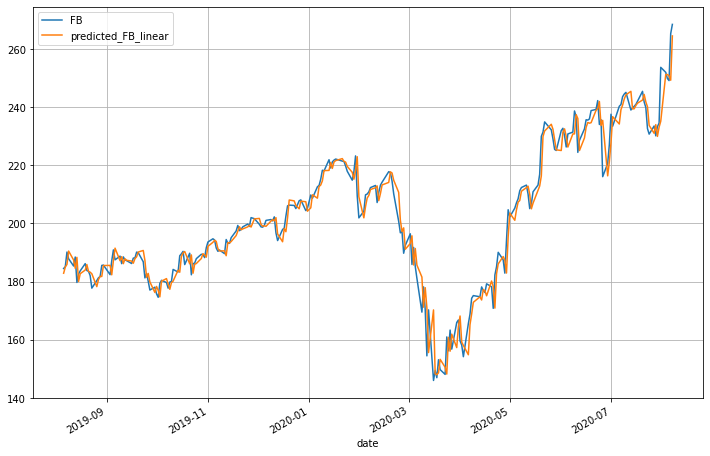

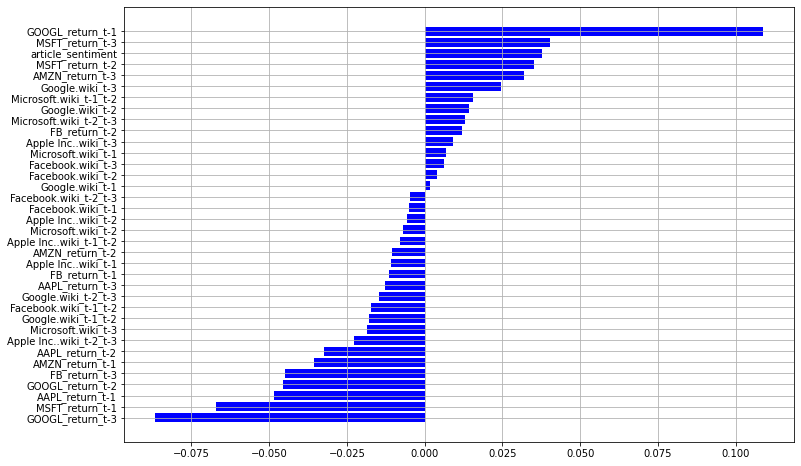

In [318]:
train_test(reg_4, train_X_sc, train_y_sc, test_X_sc, test_y_sc, LGBM = False, SVR =  True)

Train
1024
1024
1024
0.5778292830386255 MAE
1.4551652643615325 RMSE
0.007301663296418857 MLSE
0.9004878048780488 MDA
Test
3.6487561369582333 MAE
26.791309230807972 RMSE
0.026952601088933173 MSLE
0.5215686274509804 MDA
36
36


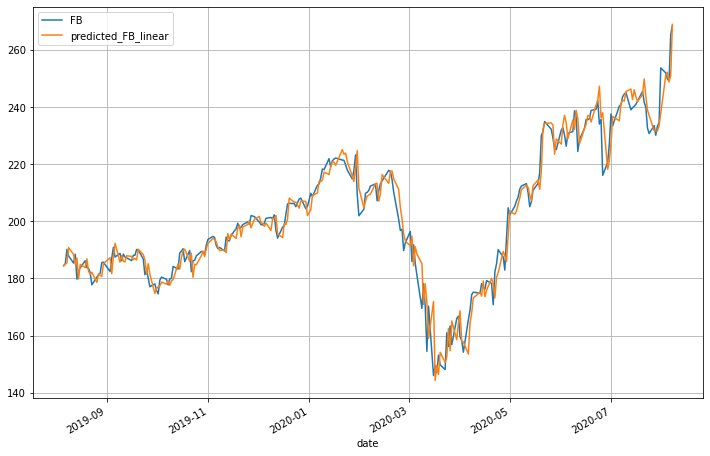

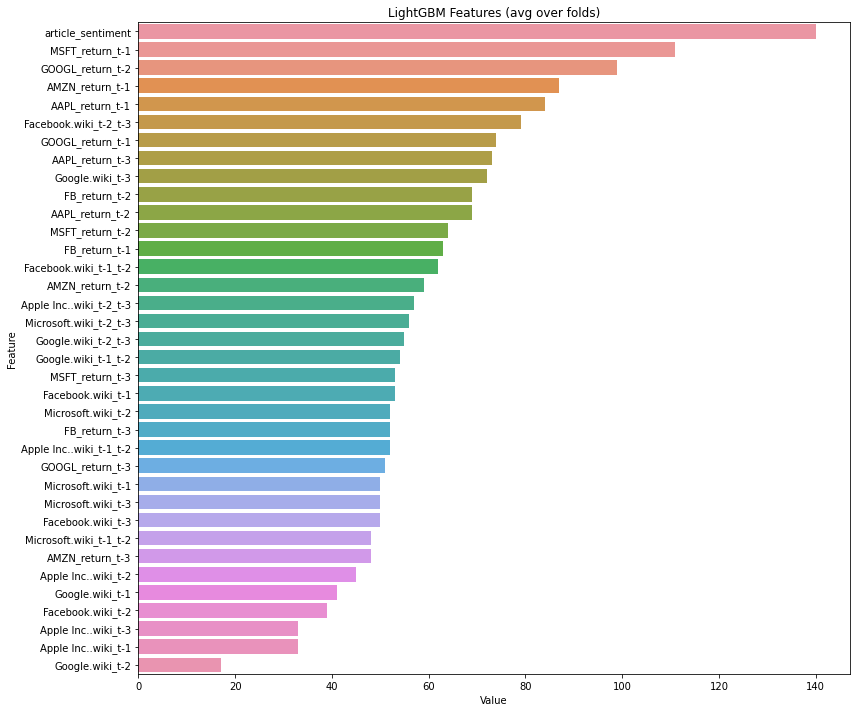

In [115]:
train_test(reg_5, data_lm, train_X_sc, train_y_sc, test_X_sc, test_y_sc, LGBM = True, SVR =  False)

In [129]:
dfv = pd.read_csv("df_transed_cleaned.csv").drop(columns = ['Unnamed: 0'])
dfv['publish_date'] = pd.to_datetime(dfv['publish_date'])
dfv['date'] = dfv['publish_date'].apply(lambda x: x.date())
dfv.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,scraped_article,title_FB_only,BOG,date,translateda_mix,translateda_headline,translateda_mix_cleaned,translateda_headline_cleaned,translateda_mix_dic,translateda_headline_dic
0,865782065,2015-01-03 18:12:00,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",https://twitter.com/TheRalphRetort/status/5515...,en,False,NaN,18346,Twitter,http://twitter.com,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",NaN,NaN,2015-01-03,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...","Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",ralph twitter appreciate big help,ralph twitter appreciate big help,"{'ralph': 1, 'twitter': 1, 'appreciate': 1, 'b...","{'ralph': 1, 'twitter': 1, 'appreciate': 1, 'b..."
1,335784736,2015-01-07 07:23:39,The Daily Rupert on Twitter: &quot;Facebook v...,https://twitter.com/TheMurdochTimes/status/552...,en,False,NaN,18346,Twitter,http://twitter.com,The Daily Rupert on Twitter: &quot;Facebook v...,NaN,NaN,2015-01-07,The Daily Rupert on Twitter: &quot;Facebook v...,The Daily Rupert on Twitter: &quot;Facebook v...,daily twitter video image terrorist outside of...,daily twitter video image terrorist outside of...,"{'daily': 1, 'twitter': 1, 'video': 1, 'image'...","{'daily': 1, 'twitter': 1, 'video': 1, 'image'..."
2,335817091,2015-01-07 12:32:58,teleSUR TV on Twitter: &quot;El Festival de Ca...,https://twitter.com/teleSURtv/status/552880585...,en,False,NaN,18346,Twitter,http://twitter.com,teleSUR TV on Twitter: &quot;El Festival de Ca...,NaN,NaN,2015-01-07,teleSUR TV on Twitter: &quot;El Festival de Ca...,teleSUR TV on Twitter: &quot;El Festival de Ca...,twitter festival de en en,twitter festival de en en,"{'twitter': 1, 'festival': 1, 'de': 1, 'en': 2}","{'twitter': 1, 'festival': 1, 'de': 1, 'en': 2}"
3,320258910,2015-01-15 21:39:09,Stop Patriarchy on Twitter: &quot;Tune in to n...,https://twitter.com/StopPatriarchy/status/5559...,en,False,NaN,18346,Twitter,http://twitter.com,Stop Patriarchy on Twitter: &quot;Tune in to n...,NaN,NaN,2015-01-15,Stop Patriarchy on Twitter: &quot;Tune in to n...,Stop Patriarchy on Twitter: &quot;Tune in to n...,stop patriarchy twitter join event,stop patriarchy twitter join event,"{'stop': 1, 'patriarchy': 1, 'twitter': 1, 'jo...","{'stop': 1, 'patriarchy': 1, 'twitter': 1, 'jo..."
4,372077690,2015-01-24 07:00:00,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,https://archive.is/ArtrI,en,False,computers and the internet,18346,Twitter,http://twitter.com,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,NaN,NaN,2015-01-24,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,blocker twitter kop could not keep mouth shut ...,blocker twitter kop could not keep mouth shut ...,"{'blocker': 1, 'twitter': 1, 'kop': 1, 'could'...","{'blocker': 1, 'twitter': 1, 'kop': 1, 'could'..."


In [144]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

In [145]:
data = data.drop(columns = ['article_sentiment_x','article_sentiment_y'])

In [146]:
dfv['translateda_mix_cleaned'] = dfv['translateda_mix_cleaned'].astype(str)

In [147]:
dfv['translateda_mix_cleaned'][0]

'ralph twitter appreciate big help'

In [148]:
dfv['article_sentiment'] =  dfv['translateda_mix_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [149]:
senti_score = dfv.groupby('date')[['article_sentiment']].sum()
senti_score.head()

,article_sentiment
date,
2015-01-03,0.8320
2015-01-07,-0.4392
2015-01-15,0.1662
2015-01-24,0.0579
2015-02-05,0.3473


In [150]:
data = data.merge(senti_score, left_index = True, right_index = True, how = 'left')
data = data.fillna(0)

In [151]:
data.head()

,Facebook.wiki,Google.wiki,Microsoft.wiki,Apple Inc..wiki,AAPL,AMZN,FB,GOOGL,MSFT,FB_return,...,AAPL_return_t-3,Facebook.wiki_t-1_t-2,Facebook.wiki_t-2_t-3,Google.wiki_t-1_t-2,Google.wiki_t-2_t-3,Microsoft.wiki_t-1_t-2,Microsoft.wiki_t-2_t-3,Apple Inc..wiki_t-1_t-2,Apple Inc..wiki_t-2_t-3,article_sentiment
date,,,,,,,,,,,,,,,,,,,,,
2015-07-10,46622,42652,7816,12394,113.411430,443.510010,87.949997,556.109985,40.275764,0.024103,...,-0.002460,0.038858,-0.011410,-0.050137,-0.046653,-0.065711,0.331405,-0.058647,0.074806,0.0000
2015-07-13,47063,44437,7857,12479,115.600922,455.570007,90.099998,571.729980,41.115414,0.024446,...,-0.024823,-0.012364,0.038858,-0.014963,-0.050137,-0.226822,-0.065711,-0.102007,-0.058647,0.0000
2015-07-14,44508,45269,7314,11447,115.554909,465.570007,89.680000,584.179993,41.187630,-0.004661,...,-0.020397,0.009415,-0.012364,0.040998,-0.014963,0.005232,-0.226822,0.006835,-0.102007,0.0000
2015-07-15,44555,44688,7583,10436,116.668060,461.190002,89.760002,583.960022,41.314034,0.000892,...,0.026734,-0.055818,0.009415,0.018550,0.040998,-0.071615,0.005232,-0.086320,0.006835,0.0000
2015-07-16,45184,44310,7442,10174,118.222786,475.480011,90.849998,601.780029,42.126591,0.012143,...,0.019306,0.001055,-0.055818,-0.012917,0.018550,0.036119,-0.071615,-0.092466,-0.086320,0.6275


In [152]:
data.tail()

,Facebook.wiki,Google.wiki,Microsoft.wiki,Apple Inc..wiki,AAPL,AMZN,FB,GOOGL,MSFT,FB_return,...,AAPL_return_t-3,Facebook.wiki_t-1_t-2,Facebook.wiki_t-2_t-3,Google.wiki_t-1_t-2,Google.wiki_t-2_t-3,Microsoft.wiki_t-1_t-2,Microsoft.wiki_t-2_t-3,Apple Inc..wiki_t-1_t-2,Apple Inc..wiki_t-2_t-3,article_sentiment
date,,,,,,,,,,,,,,,,,,,,,
2020-08-03,17430,26244,11438,12808,434.965759,3111.889893,251.960007,1482.760010,216.017807,-0.006741,...,0.019168,-0.172341,0.039589,-1.363145,0.404453,-0.097668,-0.006159,0.086925,-0.058457,1.3454
2020-08-04,16527,18095,9991,13311,437.870514,3138.830078,249.830002,1473.300049,212.775650,-0.008454,...,0.012100,0.155557,-0.172341,-0.168838,-1.363145,0.484339,-0.097668,-0.071187,0.086925,0.0000
2020-08-05,16654,19028,8099,13297,439.457642,3205.030029,249.119995,1479.089966,212.426498,-0.002842,...,0.104689,-0.053197,0.155557,-0.371802,-0.168838,-0.135256,0.484339,0.038521,-0.071187,0.0000
2020-08-06,14263,16961,7288,12109,454.790009,3225.000000,265.279999,1504.949951,215.828278,0.064868,...,0.025198,0.007655,-0.053197,0.050276,-0.371802,-0.209944,-0.135256,-0.001052,0.038521,0.2041
2020-08-07,13744,15969,7916,12518,444.450012,3167.459961,268.440002,1498.369995,211.967606,0.011912,...,0.006678,-0.154982,0.007655,-0.114995,0.050276,-0.105511,-0.209944,-0.093589,-0.001052,0.1436


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1280 entries, 2015-07-10 to 2020-08-07
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Facebook.wiki            1280 non-null   int64  
 1   Google.wiki              1280 non-null   int64  
 2   Microsoft.wiki           1280 non-null   int64  
 3   Apple Inc..wiki          1280 non-null   int64  
 4   AAPL                     1280 non-null   float64
 5   AMZN                     1280 non-null   float64
 6   FB                       1280 non-null   float64
 7   GOOGL                    1280 non-null   float64
 8   MSFT                     1280 non-null   float64
 9   FB_return                1280 non-null   float64
 10  FB_change                1280 non-null   float64
 11  GOOGL_return             1280 non-null   float64
 12  GOOGL_change             1280 non-null   float64
 13  MSFT_return              1280 non-null   float64
 14  MSFT_c

In [342]:
train_test_split = 0.80
total_days = len(data.index)
split_week = data.index[round(total_days*(train_test_split))]
train = data[data.index <= split_week]
test = data[data.index > split_week]
print(split_week)
print(train.shape)
print(test.shape)

2019-08-05 00:00:00
(1025, 55)
(255, 55)


In [343]:
train_X, train_y = train[data.columns[19:]], train['FB_return']
test_X, test_y = test[data.columns[19:]], test['FB_return']
train_X_sc, train_y_sc = x_sc.fit_transform(train_X), y_sc.fit_transform(train_y.values.reshape(-1, 1))
test_X_sc, test_y_sc = x_sc.transform(test_X), y_sc.transform(test_y.values.reshape(-1, 1))

Train
1024
1024
1024
1.7373921795114626 MAE
7.973640568048985 RMSE
0.018375041350478613 MLSE
0.5629268292682926 MDA
Test
3.3586532419038737 MAE
24.21617518837082 RMSE
0.02570795807140674 MSLE
0.5882352941176471 MDA
36


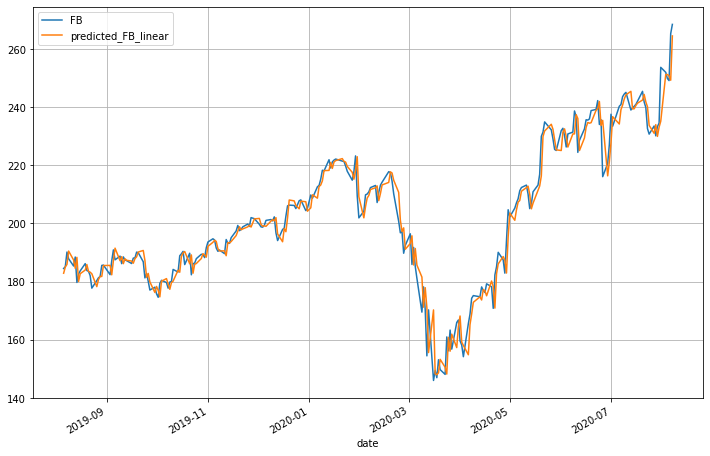

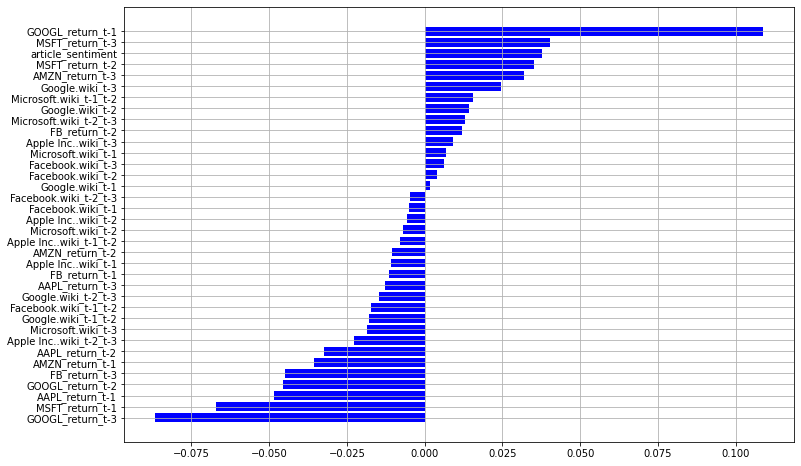

In [156]:
train_test(reg_4, data_lm, train_X_sc, train_y_sc, test_X_sc, test_y_sc , LGBM = False, SVR = True)

Train
1024
1024
1024
0.5778292830386255 MAE
1.4551652643615325 RMSE
0.007301663296418857 MLSE
0.9004878048780488 MDA
Test
3.6487561369582333 MAE
26.791309230807972 RMSE
0.026952601088933173 MSLE
0.5215686274509804 MDA
36
36


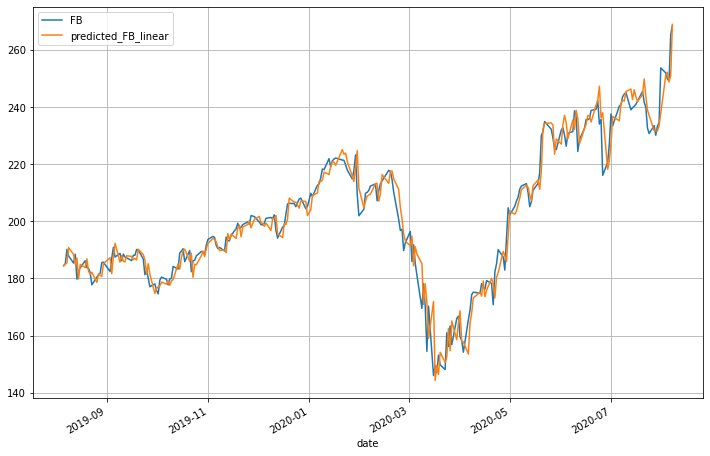

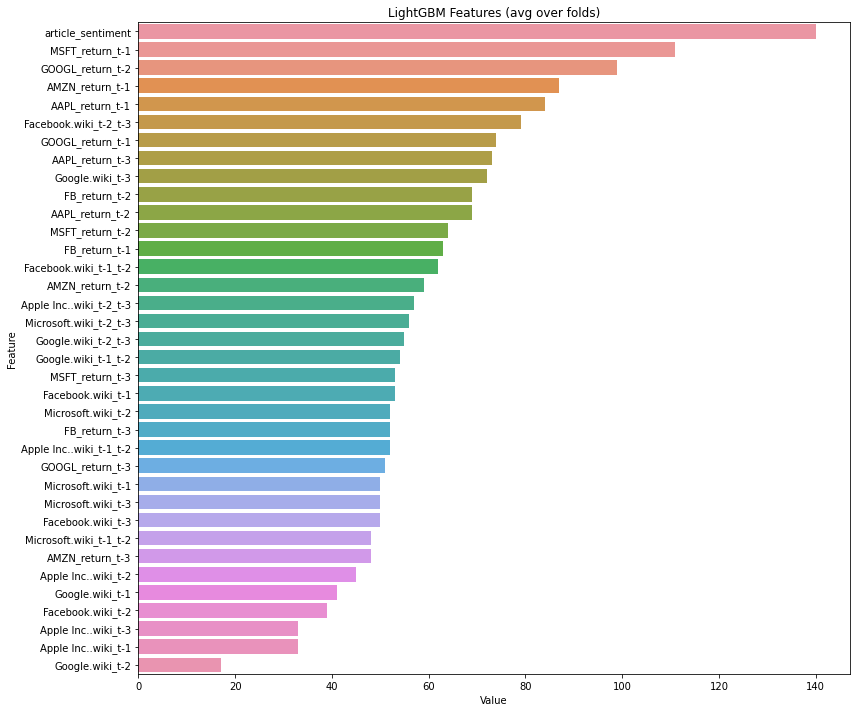

In [157]:
train_test(reg_5, data_lm, train_X_sc, train_y_sc, test_X_sc, test_y_sc , LGBM = True, SVR = False)

In [191]:
%matplotlib inline

# Load the Python scripts that contain the Bayesian optimization code
%run ./../gp.py
%run ./../plotters.py

ERROR:root:File `'./../gp.py'` not found.
ERROR:root:File `'./../plotters.py'` not found.


In [344]:
reg_4 = SVR(kernel='linear')

In [307]:
reg_5 = lgb.LGBMRegressor()

In [305]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [296]:
time_split = TimeSeriesSplit(n_splits=5)

In [297]:
print(train_X_sc.shape, train_y_sc.shape)
print(test_X_sc.shape, test_y_sc.shape)

(1025, 36) (1025, 1)
(255, 36) (255, 1)


In [298]:
c_values = np.linspace(0, 1, num=15)

In [310]:
#LGB
class_weight = [None,'balanced']
boosting_type = ['gbdt', 'goss', 'dart']
num_leaves = [30,50,100,150] #list(range(30, 150)),
learning_rate = list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)) #1000
max_depth = [2,3,4,5,10,15]
lgg_grid = dict(class_weight=class_weight, boosting_type=boosting_type, num_leaves=num_leaves, learning_rate =learning_rate,max_depth = max_depth )

In [311]:
lgg_grid 

{'class_weight': [None, 'balanced'],
 'boosting_type': ['gbdt', 'goss', 'dart'],
 'num_leaves': [30, 50, 100, 150],
 'learning_rate': [0.005000000000000004,
  0.007533150951473343,
  0.01134967265153673,
  0.01709975946676697,
  0.02576301385940817,
  0.03881533447356429,
  0.05848035476425732,
  0.08810826802697265,
  0.1327465766240114,
  0.20000000000000004],
 'max_depth': [2, 3, 4, 5, 10, 15]}

In [313]:
RCV_2 = RandomizedSearchCV(estimator=reg_5 , 
                           param_distributions= lgg_grid  ,  
                           scoring='neg_root_mean_squared_error', 
                           n_jobs=-1, 
                           cv=time_split, 
                           verbose=50)

In [299]:
RCV = GridSearchCV(estimator=reg_4 , param_grid={'C': c_values}, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=time_split, verbose=50)

In [300]:
RCV.fit(train_X_sc, train_y_sc)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  18 task

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])},
             scoring='neg_root_mean_squared_error', verbose=50)

In [302]:
RCV.best_score_, RCV.best_params_, RCV.best_estimator_

(-0.9626547563925006,
 {'C': 0.07142857142857142},
 SVR(C=0.07142857142857142, kernel='linear'))

In [314]:
RCV_2.fit(train_X_sc, train_y_sc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=LGBMRegressor(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'goss',
                                                          'dart'],
                                        'class_weight': [None, 'balanced'],
                                        'learning_rate': [0.005000000000000004,
                                                          0.007533150951473343,
                                                          0.01134967265153673,
                                                          0.01709975946676697,
                                                          0.02576301385940817,
                                                          0.03881533447356429,
                                                          0.05848035476425732,
                                                          0.08810826802697265,
                    

In [315]:
RCV_2.best_score_, RCV_2.best_params_, RCV_2.best_estimator_

(-0.9132554283380315,
 {'num_leaves': 150,
  'max_depth': 3,
  'learning_rate': 0.01134967265153673,
  'class_weight': 'balanced',
  'boosting_type': 'dart'},
 LGBMRegressor(boosting_type='dart', class_weight='balanced',
               learning_rate=0.01134967265153673, max_depth=3, num_leaves=150))

In [323]:
59.61 - 58.82

0.7899999999999991

In [326]:
def train_test(reg, train_X_sc, train_y_sc, test_X_sc, test_y_sc , LGBM = True, SVR = True, Linear = True): 

    reg.fit(train_X_sc,train_y_sc)

    y_hat_train = y_sc.inverse_transform(reg.predict(train_X_sc))
    print('Train')
    train['predict_return_linear'] = y_hat_train
    stock_yesterday = [i for i in list(data['FB'].loc["2015-07-10":"2019-08-02"])]
    print(len(stock_yesterday))
    return_pred = [i for  i in list(train['predict_return_linear'].loc["2015-07-13":'2019-08-05'])]
    print(len(return_pred))
    pred_stock = [i1 * (1+i2) for (i1,i2) in zip(stock_yesterday,return_pred)]
    print(len(pred_stock)) 
    train['predicted_FB_linear'] = [pred_stock[0]] * len(train.index)
    train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05'] = pred_stock

    print(mean_absolute_error(train['FB'].iloc[1:], train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']),'MAE')
    print(mean_squared_error(train['FB'].iloc[1:], train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']),'RMSE')
    print(np.sqrt(mean_squared_log_error(abs(train['FB'].iloc[1:]), abs(train['predicted_FB_linear'].loc['2015-07-13':'2019-08-05']))),'MLSE')
    #print(mda(train['FB'].iloc[1:].values, train['predicted_FB_linear'].dropna().values),'MDA')
    print(MDA(train, 'predicted_FB_linear'),'MDA') 

    y_hat_test = y_sc.inverse_transform(reg.predict(test_X_sc)) 
    test['predict_return_linear'] = y_hat_test 

    stock_yesterday = [i for i in list(data['FB'].loc['2019-08-05':'2020-08-06'])]
    return_pred = [i for  i in list(test['predict_return_linear'])]

    pred_stock = [i1 * (1+i2) for (i1,i2) in zip(stock_yesterday,return_pred)]
    
    print('Test')
    test['predicted_FB_linear'] = pred_stock
    #test['predicted_FB_linear'] = stock_true * (1 + test['predict_return_linear']) 
    print(mean_absolute_error(test['FB'], test['predicted_FB_linear']), 'MAE')
    print(mean_squared_error(test['FB'], test['predicted_FB_linear']),'RMSE')
    print(np.sqrt(mean_squared_log_error(abs(test['FB']), abs(test['predicted_FB_linear']))),'MSLE')
    #print(mda(test['FB'].values, test['predicted_FB_linear'].values),'MDA')
    print(MDA(test,'predicted_FB_linear'),'MDA')

    plt.figure(figsize = (12,8))
    test['FB'].plot(legend = True)
    test['predicted_FB_linear'].plot(legend = True)
    plt.grid()
    
    if LGBM == True : 
        non_zero_importance_name = train_X.columns[reg.feature_importances_ != 0]
        non_zero_importance_value = reg.feature_importances_[reg.feature_importances_ != 0]
        print(len(non_zero_importance_name))
        print(len(non_zero_importance_value))

        if len(non_zero_importance_name) != 0: 

            # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
            feature_imp = pd.DataFrame(sorted(zip(non_zero_importance_value , non_zero_importance_name)), columns=['Value','Feature'])
            plt.figure(figsize=(12, 10))
            sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
            plt.title('LightGBM Features (avg over folds)')
            plt.tight_layout()
            plt.show()

    if SVR == True and Linear == True: 
        list_of_coed = list(reg.coef_[0])
        important = []
        for i in range(len(list_of_coed)): 
            if list_of_coed[i] - list_of_coed[i-1]!= 0 and abs(list_of_coed[i]) >= 1e-05: 
                important.append(list_of_coed[i])
        print(len(important))

        def f_importances(coef, names):
            imp = coef
            imp,names = zip(*sorted(zip(imp,names)))
            plt.figure(figsize=(12,8))
            plt.barh(range(len(names)), imp, align='center', color = 'blue')
            plt.yticks(range(len(names)), names)
            plt.grid()
            plt.show()

        features_names = train_X.columns[0:len(important)]
        f_importances(important, features_names)
    
    return test

Train
1024
1024
1024
1.7371397466349934 MAE
7.973629940941736 RMSE
0.01837756512256015 MLSE
0.5619512195121952 MDA
Test
3.3591213996862685 MAE
24.24015354387759 RMSE
0.025718728008173944 MSLE
0.596078431372549 MDA
36


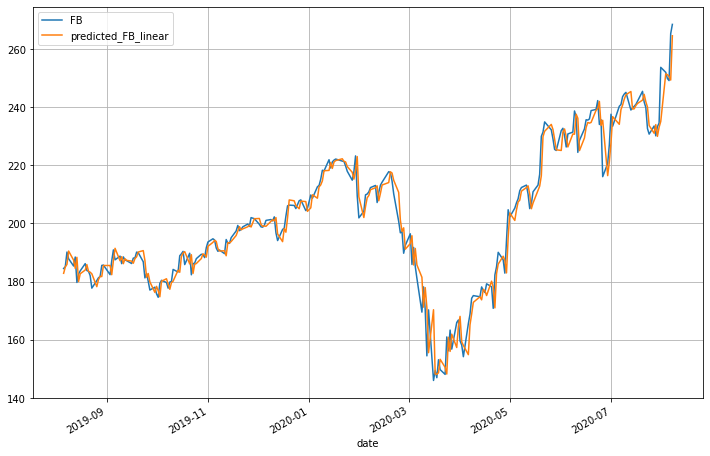

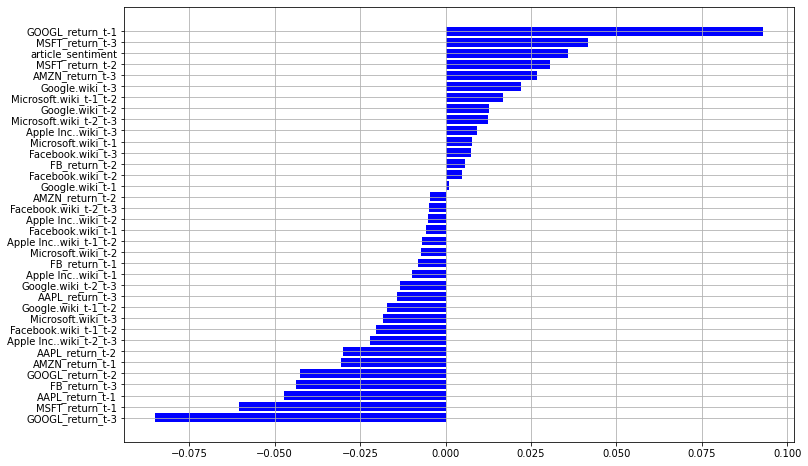

In [345]:
test = train_test(RCV.best_estimator_, train_X_sc, train_y_sc, test_X_sc, test_y_sc , 
           LGBM = False, SVR = True, Linear = True)

In [330]:
test[['FB','predicted_FB_linear']].to_csv('prediction_optimal.csv')

Train
1024
1024
1024
1.7405848299459796 MAE
7.697276557302415 RMSE
0.01814147573052293 MLSE
0.5863414634146341 MDA
Test
3.392054565038615 MAE
24.869718527874358 RMSE
0.02609667476601562 MSLE
0.5372549019607843 MDA
17
17


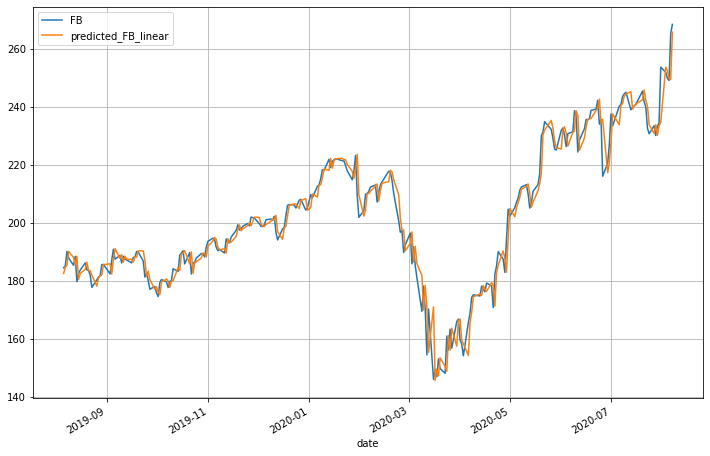

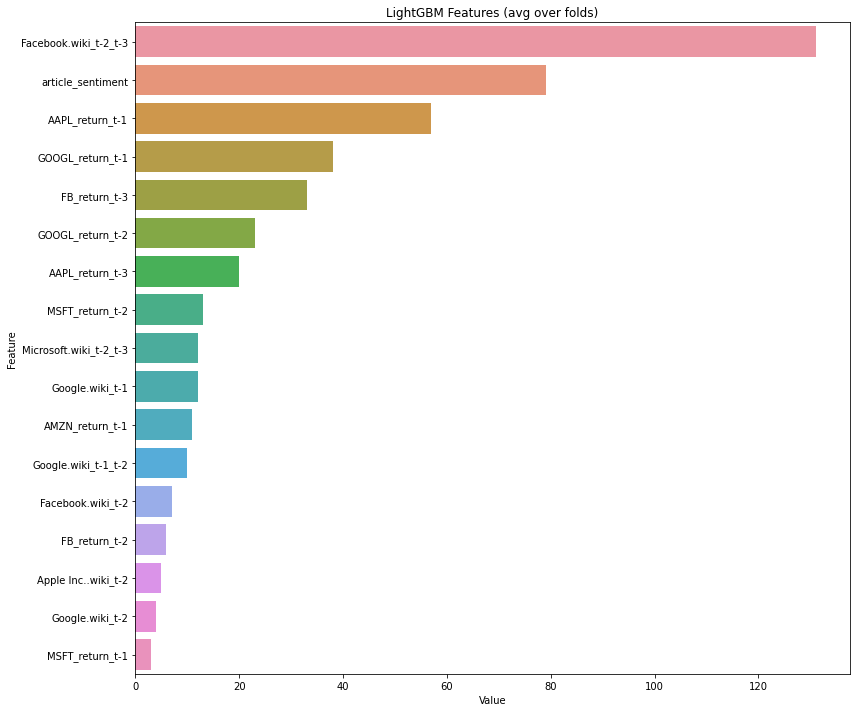

In [322]:
train_test(RCV_2.best_estimator_, train_X_sc, train_y_sc, test_X_sc, test_y_sc , 
           LGBM = True, SVR = False, Linear = False)

In [346]:
train = train.dropna()
train[['FB','predicted_FB_linear']]

,FB,predicted_FB_linear
date,,
2015-07-10,87.949997,88.284368
2015-07-13,90.099998,88.284368
2015-07-14,89.680000,90.032952
2015-07-15,89.760002,89.621640
2015-07-16,90.849998,89.634163
...,...,...
2019-07-30,197.039993,195.092190
2019-07-31,194.229996,195.186984
2019-08-01,192.729996,194.680379


In [360]:
def MDA(data, predicted_name): 
    correct = 0
    df = data[['FB',predicted_name]].reset_index()
    for i, r in df.iterrows(): 
        if  i  > 0: 
            if r[predicted_name] > df.at[i-1, 'FB']: 
                if r['FB'] > df.at[i-1, 'FB']: 
                    df.at[i,'correct'] = 1
                    correct += 1 
            if r[predicted_name] < df.at[i-1, 'FB']: 
                if r['FB'] < df.at[i-1, 'FB']: 
                    df.at[i,'correct'] = 1
                    correct += 1 
            else: 
                df.at[i,'correct'] = 0
    return (correct/df.shape[0]), df, correct 

In [361]:
d = train[['FB','predicted_FB_linear']]
out, d,correct = MDA(d , 'predicted_FB_linear')

In [362]:
out

0.5619512195121952

In [363]:
correct/d

576

In [359]:
d = d.fillna(0)
d.head(50)

,date,FB,predicted_FB_linear,correct
0,2015-07-10,87.949997,88.284368,0.0
1,2015-07-13,90.099998,88.284368,0.0
2,2015-07-14,89.680000,90.032952,1.0
3,2015-07-15,89.760002,89.621640,0.0
4,2015-07-16,90.849998,89.634163,0.0
5,2015-07-17,94.970001,90.961614,0.0
6,2015-07-20,97.910004,96.587040,0.0
7,2015-07-21,98.389999,96.804130,0.0
8,2015-07-22,97.040001,96.856651,1.0
9,2015-07-23,95.440002,97.814592,0.0


In [341]:
print(max([abs(x) for x in list(train['predicted_FB_linear'] - train['FB'])]))
print(min([abs(x) for x in list(train['predicted_FB_linear'] - train['FB'])]))
print(np.array([abs(x) for x in list(train['predicted_FB_linear'] - train['FB'])]).mean())


2.4685507109288096
0.00034957376468014445
0.3078664107254234
